# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [2]:
import re,string

import os
import time
import torch
import pickle
import datetime
import numpy as np
import pandas as pd

from pathlib import Path

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]='2,3,4,5'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  print("=================================")
  print("GPU found")
  print("Using GPU at cuda:",torch.cuda.current_device())
  print("=================================")
  print(" ")

GPU found
Using GPU at cuda: 0
 


# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [42]:
data = pd.read_csv('https://raw.githubusercontent.com/SouravDutta91/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv',sep='\t')
data_text = data['text']
textd = data_text[:100]

In [43]:
data.head(10)

,text_id,text,task_1,task_2,task_3
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE
5,hasoc_hi_5121,मुंबई में बारिश से लोगों को काफी समस्या हो रही है,NOT,NONE,NONE
6,hasoc_hi_7142,Ahmed's dad:-- beta aaj teri mammy kyu nahi ba...,NOT,NONE,NONE
7,hasoc_hi_4321,"5 लाख मुसलमान उर्स में, अजमेर की दरगाह पर आते ...",NOT,NONE,NONE
8,hasoc_hi_4674,"Do mahashaktiyan mili hain, charo taraf khusi ...",NOT,NONE,NONE
9,hasoc_hi_1637,Chants of 'Jai Sri Ram' as Owaisi takes oath: ...,NOT,NONE,NONE


## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [44]:
def punctuations_remove(input):
  output = "".join([x for x in input if x not in string.punctuation])
  return output

def numbers_remove(input):
  output = re.sub(r"[0-9]+", "", input)
  return output

def usernames_remove(input):
  output = re.sub(r"@\S+", "", input)
  return output

def hashtag_remove(input):
  output = re.sub(r"#\S+", "", input)
  return output

def http_remove(input):
  output = re.sub(r"http\S+", "", input)
  return output

def emojis_remove(input):
  EMOJI_PATTERN = re.compile(
      "["
      "\U0001F1E0-\U0001F1FF"  # flags (iOS)
      "\U0001F300-\U0001F5FF"  # symbols & pictographs
      "\U0001F600-\U0001F64F"  # emoticons
      "\U0001F680-\U0001F6FF"  # transport & map symbols
      "\U0001F700-\U0001F77F"  # alchemical symbols
      "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
      "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
      "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
      "\U0001FA00-\U0001FA6F"  # Chess Symbols
      "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
      "\U00002702-\U000027B0"  # Dingbats
      "\U000024C2-\U0001F251" 
      "]+"
  )
  
  output = EMOJI_PATTERN.sub(r'',input)
  return output

def extra_whitespaces(input):
  output = input.replace('\s+', ' ')
  return output

def stopwords_remove(m):
  hindi_stopwords = pd.read_csv('https://raw.githubusercontent.com/stopwords-iso/stopwords-hi/master/stopwords-hi.txt').stack().tolist()
  english_stopwords = pd.read_csv('https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt').stack().tolist()
  stopwords = hindi_stopwords + english_stopwords

  output = pd.Series(m).apply(lambda x: [item for item in x.split() if item not in stopwords])
  return output

def tolower(input):
  output = input.lower()
  return output

def corpus_preprocess(corpus):
  corpus = corpus.apply(lambda x: tolower(x))
  corpus = corpus.apply(lambda x: emojis_remove(x))
  corpus = corpus.apply(lambda x: http_remove(x))
  corpus = corpus.apply(lambda x: hashtag_remove(x))
  corpus = corpus.apply(lambda x: numbers_remove(x))
  corpus = corpus.apply(lambda x: usernames_remove(x))
  corpus = corpus.apply(lambda x: punctuations_remove(x))
  corpus = corpus.apply(lambda x: stopwords_remove(x))
  corpus = corpus.apply(lambda x: extra_whitespaces(x))
  return corpus

In [45]:
print("Started Preprocessing")
cleanstart = time.time()
cleantext = corpus_preprocess(textd)
cleanend = str(datetime.timedelta(seconds = time.time()-cleanstart))
print("Preprocessing ended!")
print("Pre-processing the text took {}".format(cleanend))
print("===========================================================")

Started Preprocessing
Preprocessing ended!
Pre-processing the text took 0:00:08.811462


In [39]:
def tokens(text):
  c = []
  for sent in text[0]:
    a = " ".join(sent)
    c.append(a)
  df_text = pd.DataFrame(c,columns=["text"])
  return df_text

In [40]:
text =  tokens(cleantext)
text = text['text'].apply(lambda x: x.split())

In [41]:
text

0           [बांग्लादेश, शानदार, वापसी, भारत, रन, रोका]
1     [सब, रंडी, नाच, देखने, व्यस्त, होगा, सब, शुरू,...
2     [तुम, हरामियों, बस, जूतों, कमी, शुक्र, तुम्हार...
3     [बीजेपी, mla, आकाश, विजयवर्गीय, जेल, रिहा, जमा...
4     [चमकी, बुखार, विधानसभा, परिसर, आरजेडी, प्रदर्श...
                            ...                        
95    [देश, पहली, बार, सरकार, प्रो, इंकम्बेंसी, जनाद...
96    [आदमी, आदमी, मैं, पानी, बारे, सोचता, थालिखने, ...
97    [मादरजात, सनी, तेरे, पास, टाइम, नही, तोतेरी, म...
98    [थोर, क्रांतिकारक, राणी, लक्ष्मीबाई, यांना, पु...
99    [मुस्लिम, लोगों, वोट, मांगने, वाली, पार्टियां,...
Name: text, Length: 100, dtype: object

## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output od the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [10]:
V = list(set(text.sum())) #List of unique words in the corpus
all_words = list(text.sum()) #All the words without removing duplicates
print("Total number of unique words are: ",len(V))

Total number of unique words are:  1097


In [11]:
V[:20]

['स्पेशली',
 'दी।',
 'hai',
 'पहचान',
 'बताया',
 'khus',
 'साहिब',
 'जाती',
 'नया',
 'श्रद्धांजलि',
 'जनता',
 'कप',
 'सवाल',
 'तैसी',
 'wale',
 'हैँ',
 'भारतीय',
 'समर्थक',
 'शत्शत्',
 'तुमहृदय']

In [12]:
#Dictionaries of words and their indexes
word_index = {word: i for i,word in enumerate(V)}
index_word = {i: word for i,word in enumerate(V)}

In [13]:
word_index['मुखिया']

152

In [14]:
index_word[7]

'जाती'

* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [15]:
def word_to_one_hot(word):
  id = V.index(word)
  onehot = [0.] * len(V)
  onehot[id] = 1.
  return torch.tensor(onehot)

get_onehot = dict((word, word_to_one_hot(word)) for word in V)

In [16]:
get_onehot['मुखिया']

tensor([0., 0., 0.,  ..., 0., 0., 0.])

## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.001}}+1\Big) \cdot \frac{0.001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [17]:
def sampling_prob(word):
  if word in all_words:
    count = all_words.count(word)
    zw_i = count / len(all_words)
    p_wi_keep = (np.sqrt(zw_i/0.001) + 1)*(0.001/zw_i)
  else:
    p_wi_keep = 0
  return p_wi_keep

In [18]:
sampling_prob('मुखिया')

2.7641229712289954

# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [19]:
def get_target_context(sentence,window):
  thres = np.random.random()

  for i,word in enumerate(sentence):
    target = word_index[sentence[i]]

    for j in range(i - window, i + window):
      if j!=i and j <= len(sentence)-1 and j>=0:
        if sampling_prob(sentence[j]) > thres:
          context = word_index[sentence[j]]
          yield target,context

# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [20]:
# Set hyperparameters
window_size = 2
embedding_size = 300

# More hyperparameters
learning_rate = 0.05
epochs = 300
batch_size = 60

# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [21]:
# Create model 
class Word2Vec(nn.Module):
  def __init__(self):
    super().__init__()
    self.v_len = len(V)
    self.es = embedding_size
    self.epochs = epochs
    
    self.w1 = nn.Linear(len(V),embedding_size,False)
    self.w2 = nn.Linear(embedding_size,len(V))
    self.soft = nn.LogSoftmax(dim = 1)

  def forward(self, one_hot):
    one_hot = self.w1(one_hot)
    one_hot=self.w2(one_hot)
    output=self.soft(one_hot)
    return output.cuda()

  def softmax(self,input):    
    output = self.soft(input)
    return output

# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

In [29]:
# Define optimizer and loss
model = Word2Vec().cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [30]:
print("=====================================")
print("The Word2Vec model: ")
print(model)
print("=====================================")

The Word2Vec model: 
Word2Vec(
  (w1): Linear(in_features=1097, out_features=300, bias=False)
  (w2): Linear(in_features=300, out_features=1097, bias=True)
  (soft): LogSoftmax(dim=1)
)


# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

In [31]:
'''Gets the corpus and creates the training data with the target and its context
and returns a dataframe containing them in terms of their indexes.
'''
def get_training_data(corpus,window):
  t,c = [],[]
  for sentence in corpus:
    data = get_target_context(sentence,window)
    for i,j in data:
      x = get_onehot[index_word[i]]
      t.append(x)
      c.append(j)
  t_data = pd.DataFrame(list(zip(t,c)),columns=["target","context"])
  return t_data

In [32]:
def train(traindata,batchsize):
  losses = []
  print("Training started")
  for epoch in range(1,epochs+1):
    total_loss = []
    for wt,wc in zip(DataLoader(traindata.target.values,batch_size=batchsize),
                     DataLoader(traindata.context.values,batch_size=batchsize)):
      wt = wt.cuda()
      wc = wc.cuda()
      optimizer.zero_grad()
      output = model(wt)
      loss = criterion(output,wc)
      total_loss.append(loss.item())
      loss.backward()
      optimizer.step()

    if epoch % 50 == 0 :
      start = time.time()
      print("===========================================================")
      print("Saving the model state")
      save_model(epoch)
      end = str(datetime.timedelta(seconds = time.time()-start))
      print("Model state saved. It was completed in {}".format(end))      
      print("===========================================================")

    if np.mean(total_loss) < 1.2:
      break;
    print("At epoch {} the loss is {}".format(epoch ,round(np.mean(total_loss),3)))
    losses.append(np.mean(total_loss))

  plt.xlabel("Epochs")
  plt.ylabel("LOSS")
  plt.plot(losses)

In [26]:
def save_model(epoch):
  torch.save(model.state_dict(),"epoch_{}.pt".format(epoch))

It took 0:00:00.318723 to collect the data
The training data has 4028 target-context pairs
Training started
At epoch 1 the loss is 7.006
At epoch 2 the loss is 6.99
At epoch 3 the loss is 6.974
At epoch 4 the loss is 6.96
At epoch 5 the loss is 6.946
At epoch 6 the loss is 6.932
At epoch 7 the loss is 6.92
At epoch 8 the loss is 6.907
At epoch 9 the loss is 6.895
At epoch 10 the loss is 6.884
At epoch 11 the loss is 6.872
At epoch 12 the loss is 6.861
At epoch 13 the loss is 6.849
At epoch 14 the loss is 6.837
At epoch 15 the loss is 6.825
At epoch 16 the loss is 6.812
At epoch 17 the loss is 6.798
At epoch 18 the loss is 6.783
At epoch 19 the loss is 6.767
At epoch 20 the loss is 6.751
At epoch 21 the loss is 6.736
At epoch 22 the loss is 6.723
At epoch 23 the loss is 6.711
At epoch 24 the loss is 6.699
At epoch 25 the loss is 6.688
At epoch 26 the loss is 6.677
At epoch 27 the loss is 6.666
At epoch 28 the loss is 6.654
At epoch 29 the loss is 6.643
At epoch 30 the loss is 6.631
At e

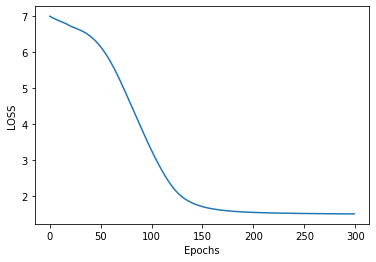

In [33]:
start2 = time.time()
print("=================================================")
print("Collecting training data")
starte = time.time()
data = get_training_data(text,window_size)
ende = str(datetime.timedelta(seconds = time.time()-starte))
print("It took {} to collect the data".format(ende))
print("The training data has {} target-context pairs".format(len(data)))
print("===================================================")

train(data,batch_size)

end2 = str(datetime.timedelta(seconds = time.time()-start2))
print("Training finished.")
print("It took {} to finish training the model".format(end2))

# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

In [46]:
data_full = pd.read_csv('https://raw.githubusercontent.com/SouravDutta91/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv',sep='\t')
full_data = data_full['text']

In [ ]:
print("Started Preprocessing")
cleantext_full = corpus_preprocess(full_data)

In [ ]:
text_full =  tokens(cleantext_full)
text_full = text_full['text'].apply(lambda x: x.split())

v = list(set(text_full.sum())) 
all_word = list(text_full.sum()) 

fullword_index = {word: i for i,word in enumerate(v)}
fullindex_word = {i: word for i,word in enumerate(v)}

data = get_training_data(text,window_size)
train(data,batch_size)